In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

import plotly.express as px

#Procesamiento de los datos

Como primer punto, cargamos los datos de la calidad del aire que previamente habíamos limpiado, los cuales contienen información horaria de las estaciones desde 2016 a 2020.

In [3]:
#Exportar los csv de los datos de entrenamiento y prueba
datos= pd.read_csv('https://raw.githubusercontent.com/IrvingC48/Prototype_BEDU/main/datasets/BaseDatos_2016_2020.csv')

In [4]:
datos.dtypes

Unnamed: 0      int64
date           object
id_station     object
PM2_5           int64
RH              int64
TMP           float64
WDR             int64
WSP           float64
hour           object
juliano         int64
dia_semana      int64
date_index      int64
zone           object
dtype: object

Después de ver las variables, procedemos a realizar el promedio diario por estación. Eliminando la columna de hora, y la de dirección del viento.

Cabe señalar, que realizamos un conteo del número de datos que se tendrán por columnas y se conserva la información de los días.

In [5]:
copia_datos= datos.drop(['Unnamed: 0','hour', 'WDR', 'date_index'], axis= 1).groupby(['date', 'id_station'])
counts = copia_datos.size().to_frame(name='counts')
datos_2= (counts
  .join(copia_datos.agg({'PM2_5': 'mean'}))
  .join(copia_datos.agg({'RH': 'mean'}))
  .join(copia_datos.agg({'TMP': 'mean'}))
  .join(copia_datos.agg({'WSP': 'mean'}))
  .join(copia_datos.agg({'juliano': 'mean'}))
  .join(copia_datos.agg({'dia_semana': 'mean'}))
  .join(copia_datos.agg({'zone': lambda x: x.iloc[0]}))
  .reset_index())

Según la normativa, aquellos promedios diarios que sean calculados con menos de 18 horas se consideran como no válidos. Por esta razón, se eliminan de este análisis

In [6]:
datos_2= datos_2[datos_2.counts>=18]


In [7]:
nuevo_station= datos_2

In [8]:
nuevo_station.tail()

,date,id_station,counts,PM2_5,RH,TMP,WSP,juliano,dia_semana,zone
17034,2020-06-30,SAG,24,18.875000,70.833333,20.287500,1.154167,182,1,NE
17035,2020-06-30,SFE,24,16.583333,65.791667,16.858333,2.141667,182,1,SO
17036,2020-06-30,TLA,20,22.350000,58.500000,19.385000,1.735000,182,1,NO
17037,2020-06-30,UAX,24,16.208333,66.625000,18.354167,1.579167,182,1,SE
17038,2020-06-30,UIZ,24,18.583333,66.083333,20.791667,1.754167,182,1,SE


#Convertir las variables de tiempo a cíclicas

Debido a que se están manejando variables temporales, se transformarán en variables numéricas para representar su variación cíclica correctamente.

Se utilizarán las funciones de seno y conseno como auxiliares para esta transformación.

In [9]:
#Tranformar los day week, los day julianos en función de seno
nuevo_station['dia_semana_sin'] = np.sin(nuevo_station['dia_semana'] * (2 * np.pi / 7)) #Por los 7 días de la semana
nuevo_station['juliano_sin'] = np.sin(nuevo_station['juliano'] * (2 * np.pi / 366)) #Por los 366 posibles días del año

#Tranformar los day week, los day julianos en función de coseno
nuevo_station['dia_semana_cos'] = np.cos(nuevo_station['dia_semana'] * (2 * np.pi / 7))
nuevo_station['juliano_cos'] = np.cos(nuevo_station['juliano'] * (2 * np.pi / 366))

#Colocar el date como un index

Para manejar correctamente la base de datos, se utilizará como un index la fecha y se eliminarán las columnas que no se utilizarán para los análisis posteriores.

In [10]:
#Eliminar las columnas que no se van a utilizar, que son las que acabamos de reemplazar, la de la estación y la primera
nuevo_station= nuevo_station.drop(['counts','juliano', 'dia_semana'], axis= 1).set_index('date')

In [11]:
nuevo_station.head()

,id_station,PM2_5,RH,TMP,WSP,zone,dia_semana_sin,juliano_sin,dia_semana_cos,juliano_cos
date,,,,,,,,,,
2016-01-01,AJU,18.571429,79.190476,8.947619,1.942857,SO,-0.433884,0.017166,-0.900969,0.999853
2016-01-02,AJU,13.391304,87.304348,8.808696,2.034783,SO,-0.974928,0.034328,-0.222521,0.999411
2016-01-02,HGM,26.391304,57.391304,16.500000,1.565217,CE,-0.974928,0.034328,-0.222521,0.999411
2016-01-02,MER,26.434783,64.304348,16.047826,2.026087,CE,-0.974928,0.034328,-0.222521,0.999411
2016-01-02,MGH,25.291667,61.750000,16.600000,1.654167,NO,-0.974928,0.034328,-0.222521,0.999411


#Transformación de variables categóricas

Tal como se observa, tenemos dos columnas con variables categóricas: la zona y  la estación. Para que se agreguen como variables al algoritmo de Machine Learning, se deben tratar como variables numéricas, en este caso, como variables booleanas.

Por lo que en seguida se muestra la manera de realizar esa transformación.

In [12]:
from sklearn.preprocessing import OneHotEncoder
#importacion del ecoder con los parametros antes mencionados
categ = (nuevo_station.dtypes == 'object')
#enlistando los nombres de cada columna
cols_categ = list(categ[categ].index)
#enlistando los nombres de cada columna
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
#codificando cada columna categorica
OH_cols_nuevo_station = pd.DataFrame(OH_encoder.fit_transform(nuevo_station[cols_categ]))
OH_cols_nuevo_station.columns= OH_encoder.get_feature_names(['id_station', 'zone'])
# Hay que poner de welta el index porque se lo quitó el codificado
OH_cols_nuevo_station.index= nuevo_station.index
#Hay que quitar las columnas categoricas
num_x_nuevo_station = nuevo_station.drop(cols_categ, axis = 1)

# Y agregar las columnas codificadas
nuevo_OH_station = pd.concat([num_x_nuevo_station, OH_cols_nuevo_station], axis = 1)


In [13]:
nuevo_OH_station

,PM2_5,RH,TMP,WSP,dia_semana_sin,juliano_sin,dia_semana_cos,juliano_cos,id_station_AJM,id_station_AJU,id_station_BJU,id_station_GAM,id_station_HGM,id_station_INN,id_station_MER,id_station_MGH,id_station_MON,id_station_MPA,id_station_NEZ,id_station_PED,id_station_SAG,id_station_SFE,id_station_TLA,id_station_UAX,id_station_UIZ,id_station_XAL,zone_CE,zone_NE,zone_NO,zone_SE,zone_SO
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,18.571429,79.190476,8.947619,1.942857,-0.433884,0.017166,-0.900969,0.999853,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-02,13.391304,87.304348,8.808696,2.034783,-0.974928,0.034328,-0.222521,0.999411,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-02,26.391304,57.391304,16.500000,1.565217,-0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-02,26.434783,64.304348,16.047826,2.026087,-0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-02,25.291667,61.750000,16.600000,1.654167,-0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,18.875000,70.833333,20.287500,1.154167,0.781831,0.017166,0.623490,-0.999853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-06-30,16.583333,65.791667,16.858333,2.141667,0.781831,0.017166,0.623490,-0.999853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-06-30,22.350000,58.500000,19.385000,1.735000,0.781831,0.017166,0.623490,-0.999853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#Cálculo del índice de calidad del aire para el $PM_{2.5}$

Considerando la actualización publicada por la Agencia de Protección Ambiental de los Estados Unidos en 2012, se elaboraron funciones para calcular el índice de calidad del aire y categoría asociada a ella.

In [14]:
def AQI(CP):
    i = 0

    if 0.0 <= CP <= 12.0:
        k = (50-0)/(12-0)
        i = k * (CP - 0) + 0
    if 12.1 <= CP <= 35.4:
        k = (100-51)/(35.4-12.1)
        i = k * (CP - 12.1) + 51
    if 35.5 <= CP <= 55.4:
        k = (150-101)/(55.4-35.5)
        i = k * (CP - 35.5) + 101
    if 55.5 <= CP <= 150.4:
        k = (200-151)/(150.4-55.5)
        i = k * (CP - 55.5) + 151
    if 150.5 <= CP <= 250.4:
        k = (300-201)/(250.4-150.5)
        i = k * (CP - 150.5) + 201
    if 250.5 <= CP <= 350.4:
        k = (400-301)/(350.4-250.5)
        i = k * (CP - 250.5) + 301
    if 350.5 <= CP <= 500.4:
        k = (500-401)/(500.4-350.5)
        i = k * (CP - 350.5) + 401

    return round(i, 3)

In [15]:
def AQI_categoria(indice):
    if indice <= 50.0:
      clase='Buena'
    elif indice <= 100.0:
      clase='Regular'
    elif indice <= 150.0:
      clase= 'Mala'
    elif indice <= 200.0:
      clase = 'Muy mala'
    else: 
      clase = 'Extremadamente mala'
    
    return clase

#Determinación del modelo

Para seleccionar el modelo de Machile Learning que se utilizará para el Sistema de Alerta Temprana, se separarán los datos de 2019 y 2020, para que sirvan a modo de prueba. El último, considerado como año atípico, donde no se espera que el modelo tenga un buen ajuste.

In [16]:
train_OH_station= nuevo_OH_station['2016-01-01':'2018-12-31']
test_2019_station=nuevo_OH_station['2019-01-01':'2019-12-31']
test_2020_station= nuevo_OH_station['2020-01-01':'2020-06-30']

In [17]:
train_OH_station.head()

,PM2_5,RH,TMP,WSP,dia_semana_sin,juliano_sin,dia_semana_cos,juliano_cos,id_station_AJM,id_station_AJU,id_station_BJU,id_station_GAM,id_station_HGM,id_station_INN,id_station_MER,id_station_MGH,id_station_MON,id_station_MPA,id_station_NEZ,id_station_PED,id_station_SAG,id_station_SFE,id_station_TLA,id_station_UAX,id_station_UIZ,id_station_XAL,zone_CE,zone_NE,zone_NO,zone_SE,zone_SO
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,18.571429,79.190476,8.947619,1.942857,-0.433884,0.017166,-0.900969,0.999853,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-02,13.391304,87.304348,8.808696,2.034783,-0.974928,0.034328,-0.222521,0.999411,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-02,26.391304,57.391304,16.500000,1.565217,-0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-02,26.434783,64.304348,16.047826,2.026087,-0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-02,25.291667,61.750000,16.600000,1.654167,-0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#Pruebas de ajuste de varios modelos

Para probar cuál de los modelos de Machile Learning podría proporcionar una mejor aproximación, se utilizará la herramienta de TimesSeriesSplit por el tipo de problema presentado.

NN: -5.102403 (0.422715)
GB: -5.364077 (0.560924)
RF: -5.317629 (0.427165)
SVR rfb: -5.381831 (0.487034)


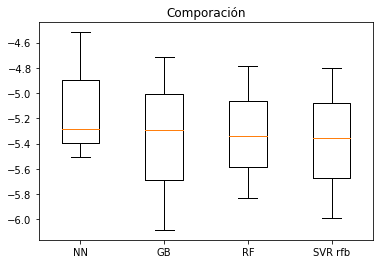

In [ ]:
#Probar con distintos de machine learning
#No correr, se tarda xd
models = []
models.append(('NN', MLPRegressor(activation = 'relu', max_iter= 1000))) 
models.append(('GB', GradientBoostingRegressor(loss='huber', n_estimators=500, criterion='mae'))) 
models.append(('RF', RandomForestRegressor(n_estimators = 500))) 
models.append(('SVR rfb', SVR(gamma='auto'))) 
#models.append(('SVR poly', SVR(kernel= 'poly', gamma='auto')))
#models.append(('SVR sigmoid', SVR(kernel= 'sigmoid', gamma='auto')))
#models.append(('KNN', KNeighborsRegressor()))
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=3)#Porque tengo 4 años completos 2016, 2017, 2018 y 2019 en el dataset de entrenamiento
    cv_results = cross_val_score(model, train_OH_station.drop('PM2_5',axis= 1), train_OH_station['PM2_5'], cv=tscv, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Comporación')
plt.show()

##Comparación sin distincion de zonas

Ajustar el mejor modelo que se encontró y revisar el ajuste que hace para los datos de prueba. En este caso, se utiliza el ajuste obtenido con redes neuronales y se evalúan algunas métricas.

In [19]:
#Ejemplo con las estaciones y las zonas
#Ajustar el mejor modelo al conjunto de prueba y revisar las métricas
import random
random.seed(7)
model = MLPRegressor(activation = 'relu', max_iter= 1000, hidden_layer_sizes=(200,))#Obtuve este modelo después de realizar un grid search
model_NN= model.fit(train_OH_station.drop(['PM2_5'],axis= 1),train_OH_station['PM2_5'])
y_true = test_2019_station['PM2_5'].values
y_pred = model_NN.predict(test_2019_station.drop(['PM2_5'],axis= 1))
r2 = metrics.r2_score(y_true, y_pred)
MAE = metrics.mean_absolute_error(y_true, y_pred)
print('r2',r2 )
print('MAE', MAE)

r2 0.4166010378892603
MAE 4.656433787706705


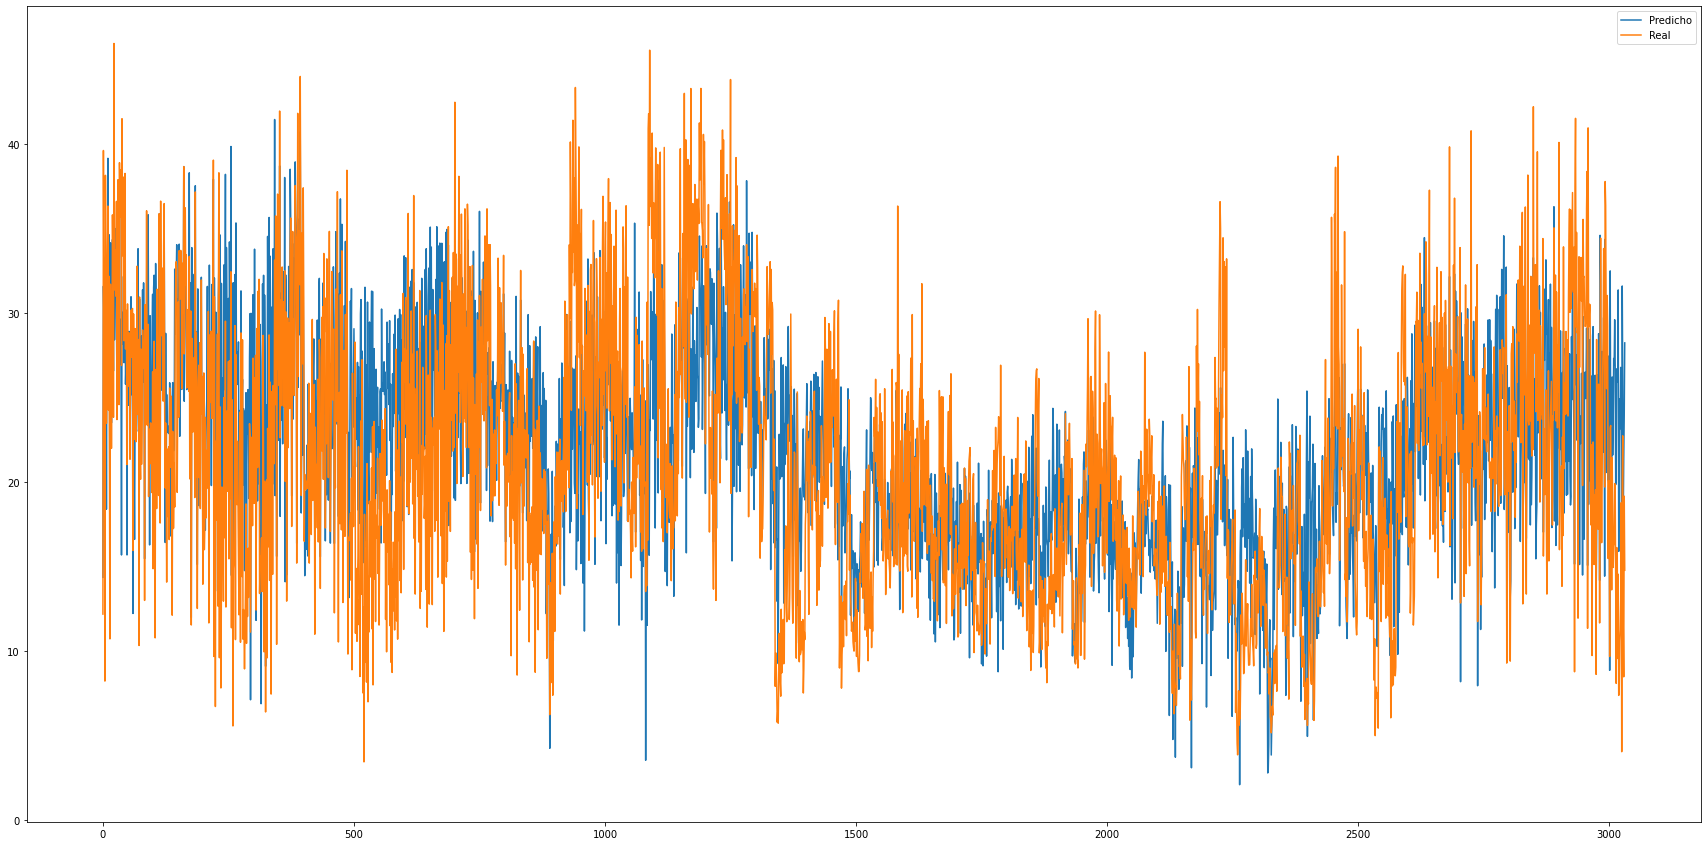

In [20]:
#Graficar el resultado
fig = plt.figure(figsize=(30, 15))
plt.plot(y_pred, label = "Predicho")
plt.plot(y_true, label = "Real")
plt.legend()
plt.show()

#Unión con el conjunto de prueba de 2019

Se añadirá al dataset de prueba los datos de la predicción de PM2.5 y el índice de calidad del aire asociado a ellos para realizar las gráficas necesarias para la presentación.

In [21]:
#Guardar la predicción en una nueva columna
test_2019_station['pred_NN']=y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
test_2019_station.head()

,PM2_5,RH,TMP,WSP,dia_semana_sin,juliano_sin,dia_semana_cos,juliano_cos,id_station_AJM,id_station_AJU,id_station_BJU,id_station_GAM,id_station_HGM,id_station_INN,id_station_MER,id_station_MGH,id_station_MON,id_station_MPA,id_station_NEZ,id_station_PED,id_station_SAG,id_station_SFE,id_station_TLA,id_station_UAX,id_station_UIZ,id_station_XAL,zone_CE,zone_NE,zone_NO,zone_SE,zone_SO,pred_NN
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,12.190476,58.190476,6.647619,1.600000,0.781831,0.017166,0.623490,0.999853,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.367920
2019-01-01,39.619048,46.523810,14.366667,1.314286,0.781831,0.017166,0.623490,0.999853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.591710
2019-01-02,30.315789,50.105263,14.168421,1.257895,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29.656517
2019-01-02,29.368421,49.210526,14.331579,1.421053,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29.922236
2019-01-02,8.227273,57.863636,5.600000,1.772727,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.475042


Se calculará el índice de calidad del aire tanto para la concentración real de $PM_{2.5}$ como para la concentración predicha

In [23]:
test_2019_station['indice_real'] = test_2019_station['PM2_5'].apply(AQI)
test_2019_station['AQI_real'] =  test_2019_station['indice_real'].apply(AQI_categoria)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
test_2019_station['indice_pred'] = test_2019_station['pred_NN'].apply(AQI)
test_2019_station['AQI_pred'] =  test_2019_station['indice_pred'].apply(AQI_categoria)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
nuevo_station.head()

,id_station,PM2_5,RH,TMP,WSP,zone,dia_semana_sin,juliano_sin,dia_semana_cos,juliano_cos
date,,,,,,,,,,
2016-01-01,AJU,18.571429,79.190476,8.947619,1.942857,SO,-0.433884,0.017166,-0.900969,0.999853
2016-01-02,AJU,13.391304,87.304348,8.808696,2.034783,SO,-0.974928,0.034328,-0.222521,0.999411
2016-01-02,HGM,26.391304,57.391304,16.500000,1.565217,CE,-0.974928,0.034328,-0.222521,0.999411
2016-01-02,MER,26.434783,64.304348,16.047826,2.026087,CE,-0.974928,0.034328,-0.222521,0.999411
2016-01-02,MGH,25.291667,61.750000,16.600000,1.654167,NO,-0.974928,0.034328,-0.222521,0.999411


In [27]:
regulador_2019= nuevo_station['2019-01-01':'2019-12-31'] #Filtrar el dataset que tienen los datos de la estación y de la zona


In [29]:
regulador_2019.head(10)

,id_station,PM2_5,RH,TMP,WSP,zone,dia_semana_sin,juliano_sin,dia_semana_cos,juliano_cos
date,,,,,,,,,,
2019-01-01,INN,12.190476,58.190476,6.647619,1.600000,SO,0.781831,0.017166,0.623490,0.999853
2019-01-01,TLA,39.619048,46.523810,14.366667,1.314286,NO,0.781831,0.017166,0.623490,0.999853
2019-01-02,BJU,30.315789,50.105263,14.168421,1.257895,CE,0.974928,0.034328,-0.222521,0.999411
2019-01-02,HGM,29.368421,49.210526,14.331579,1.421053,CE,0.974928,0.034328,-0.222521,0.999411
2019-01-02,INN,8.227273,57.863636,5.600000,1.772727,SO,0.974928,0.034328,-0.222521,0.999411
2019-01-02,MER,38.150000,55.150000,14.155000,1.580000,CE,0.974928,0.034328,-0.222521,0.999411
2019-01-02,MGH,33.571429,43.523810,14.652381,1.180952,NO,0.974928,0.034328,-0.222521,0.999411
2019-01-02,MON,23.476190,56.238095,12.457143,2.352381,NE,0.974928,0.034328,-0.222521,0.999411
2019-01-02,TLA,30.238095,50.904762,13.547619,1.609524,NO,0.974928,0.034328,-0.222521,0.999411


In [28]:
test_2019_station.head(10)

,PM2_5,RH,TMP,WSP,dia_semana_sin,juliano_sin,dia_semana_cos,juliano_cos,id_station_AJM,id_station_AJU,id_station_BJU,id_station_GAM,id_station_HGM,id_station_INN,id_station_MER,id_station_MGH,id_station_MON,id_station_MPA,id_station_NEZ,id_station_PED,id_station_SAG,id_station_SFE,id_station_TLA,id_station_UAX,id_station_UIZ,id_station_XAL,zone_CE,zone_NE,zone_NO,zone_SE,zone_SO,pred_NN,indice_real,AQI_real,indice_pred,AQI_pred
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,12.190476,58.190476,6.647619,1.600000,0.781831,0.017166,0.623490,0.999853,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.367920,51.190,Regular,55.769,Regular
2019-01-01,39.619048,46.523810,14.366667,1.314286,0.781831,0.017166,0.623490,0.999853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.591710,111.142,Mala,91.991,Regular
2019-01-02,30.315789,50.105263,14.168421,1.257895,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29.656517,89.308,Regular,87.921,Regular
2019-01-02,29.368421,49.210526,14.331579,1.421053,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29.922236,87.316,Regular,88.480,Regular
2019-01-02,8.227273,57.863636,5.600000,1.772727,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.475042,34.280,Buena,51.789,Regular
2019-01-02,38.150000,55.150000,14.155000,1.580000,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,33.289932,107.525,Mala,95.563,Regular
2019-01-02,33.571429,43.523810,14.652381,1.180952,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.454864,96.155,Regular,89.600,Regular
2019-01-02,23.476190,56.238095,12.457143,2.352381,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18.397279,74.924,Regular,64.243,Regular
2019-01-02,30.238095,50.904762,13.547619,1.609524,0.974928,0.034328,-0.222521,0.999411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29.537837,89.144,Regular,87.672,Regular


In [30]:
test_2019_station['id_station']=regulador_2019['id_station']
test_2019_station['zone']=regulador_2019['zone']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
test_2019_station.to_csv('test_2019_resultado.csv') #Guardarlo en un csv